In [2]:
import sys
import json
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import Delaunay
from skimage.measure import regionprops

sys.path.append("code/preprocessing/utils/")
from file_handling import import_stack
from segment2D import get_pixel_size


sys.path.append("code/analysis/utils")
from data_class import SegmentationData

In [3]:
# experimental parameters
frames_to_hours = 1 / 12
pix_to_um = get_pixel_size()[1]

# tracking
search_range = 20
memory = 5
threshold = 5

In [4]:
# load dataset 
dataset = "holomonitor_20240301_B1-4"
# config  = json.load(open(f"data/experimental/configs/{dataset}.json"))
# im_areas   = np.load(f"data/experimental/processed/{dataset}/im_cell_areas_tracked.npy")
# im_heights = import_stack(f"data/experimental/raw/{dataset}/", config)
cellprop = SegmentationData(f"data/experimental/processed/{dataset}/cell_props.p")

State loaded from data/experimental/processed/holomonitor_20240301_B1-4/cell_props.p.


In [66]:
# # get region properties
# cellprops = [regionprops(im_areas[i], im_heights[i]) for i in range(len(im_areas))]
# densities = [10**6 * len(cells) / (np.sum(areas > 0) * pix_to_um**2) for cells, areas in zip(cellprops, im_areas)]


# # prepare data frame
# positions = np.concatenate([[cell.centroid_weighted for cell in cellprop] for cellprop in cellprops])
# frames    = np.concatenate([[frame for cell in cellprops[frame]] for frame in range(len(cellprops))])
# labels    = np.concatenate([[cell.label for cell in cellprop] for cellprop in cellprops])

# cell_df = pd.DataFrame({'y': positions.T[0],
#                         'x': positions.T[1],
#                         'label': labels,
#                         'frame': frames})


# # tracks cells
# tracks = tp.link(cell_df, search_range=search_range, memory=memory);
# tracks = tp.filter_stubs(tracks, threshold=threshold);


# # get arrays for neighbour computation
# particle_id = tracks.particle.values
# positions   = np.array([tracks.y.values, tracks.x.values]).T
# frames      = tracks.frame.values

particle_id = np.arange(len(cellprop.x[0]))
positions   = np.array([cellprop.y, cellprop.x]).T
frames      = np.arange(len(cellprop.x))

particle_id[:20]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [61]:
# perpare matrix
Nframes, Ncells = np.shape(cellprop.x)
neighbors_matrix = np.zeros([Nframes, Ncells, Ncells])

particles = np.arange(Ncells)

# fill matrix
for frame in tqdm(range(2)):#len(neighbors_matrix))):

    # get cell positions
    positions   = np.array([cellprop.y[frame].compressed(),
                            cellprop.x[frame].compressed()]).T
    
    # get particle id of cells present in frame
    particle_id = particles[~cellprop.x[frame].mask]

    # triangulation
    tri = Delaunay(positions)

    # loop through cells
    for cell_idx in particle_id: 

        # Find neighbors from triangulation
        neighbors_idx = set()
        for simplex in tri.simplices:

            if cell_idx in simplex:
                neighbors_matrix[frame, cell_idx, particle_id[simplex]] = 1
                
                neighbors_idx.update(simplex)

# remove diagonal
for i in range(len(neighbors_matrix[0])):
    neighbors_matrix[:,i,i] = 0

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


(400.0, 0.0)

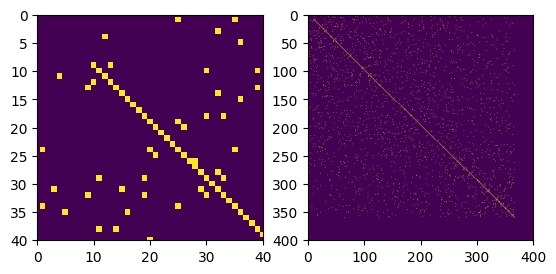

In [64]:
C_t = neighbors_matrix

plt.subplot(121)
plt.imshow(C_t[1])
plt.xlim(0, 40)
plt.ylim(40, 0)

plt.subplot(122)
plt.imshow(C_t[1])
plt.xlim(0, 400)
plt.ylim(400, 0)

# for c in range(C_t[0]):
#     nbhr = np.where(C_t[0,c] == 1)

#     if np.sum(C_t[0,c] * C_t[0, nbhr], axis=(0,2))

# nbhr = np.where(C_t[0,0] == 1)
# if np.any(np.sum(C_t[0,0] * C_t[0, nbhr], axis=(0,2))) == 2.0: print("yay")

# nbhr, np.where(C_t[0,302] == 1), np.sum(C_t[0,0] * C_t[0,302])


In [54]:
def count_T1_and_T3_transitions(C_t, C_t_plus_1):
    # Ensure the matrices are boolean
    C_t = C_t.astype(bool)
    C_t_plus_1 = C_t_plus_1.astype(bool)

    num_cells = C_t.shape[0]
    T1_count = 0
    T3_count = 0

    # Iterate over all pairs of cells
    for i in range(num_cells):
        # Find all neighbors of cell i at time t
        neighbors = np.where(C_t[i] == 1)[0]

        # Iterate over pairs of neighbors to form triangles
        for j in neighbors:
            if j <= i:  # Avoid redundancy since we check (i, j)
                continue
            
            for k in neighbors:
                if k <= i or k <= j:  # Avoid redundancy and self-loops
                    continue

                # We have a triangle (i, j, k) if all connections are present at time t
                if C_t[i, j] and C_t[i, k] and C_t[j, k]:
                    # Check for T1 transition
                    triangle_in_next = (C_t_plus_1[i, j], C_t_plus_1[i, k], C_t_plus_1[j, k])
                    
                    # A T1 transition occurs if any of the edges are missing
                    if not (triangle_in_next[0] and triangle_in_next[1] and triangle_in_next[2]):
                        T1_count += 1
                    
                    # Check for T3 transition
                    # Identify if new connections form or current ones break, 
                    # considering their states in a T3 context.
                    if (C_t_plus_1[i, j] != C_t[i, j]) or (C_t_plus_1[i, k] != C_t[i, k]) or (C_t_plus_1[j, k] != C_t[j, k]):
                        # If the triangle is disrupted or created
                        T3_count += 1

    return T1_count, T3_count


# Count T1 and T3 transitions
num_T1_transitions, num_T3_transitions = count_T1_and_T3_transitions(neighbors_matrix[0], neighbors_matrix[1])
print(f'T1 transitions counted: {num_T1_transitions}')
print(f'T3 transitions counted: {num_T3_transitions}')


T1 transitions counted: 616
T3 transitions counted: 616


In [112]:
# compute bond_breaking correlations
bond_breaking = np.zeros([Nframes, Nframes])

for i in tqdm(range(Nframes)):
    j = Nframes - i
    bond_breaking[:j,i] = np.sum((neighbors_matrix * np.roll(neighbors_matrix, shift=-i, axis=0))[:j], axis=(1,2))

for i in range(Nframes):
    bond_breaking[i] /= bond_breaking[i,0]

100%|██████████| 109/109 [00:51<00:00,  2.14it/s]


In [ ]:
# compute distribution of # neighbours
Nneighbors = np.sum(neighbors_matrix, axis=2)
nmax = int(np.max(Nneighbors))
neighbors_dist = np.zeros([Nframes, nmax])

for f in range(Nframes):
    neighbors_dist[f] = np.histogram(Nneighbors[f], density=True, range=(1, nmax))[0]


In [1]:
np.histogram(Nneighbors[f], density=True, range=(1, nmax))

NameError: name 'np' is not defined

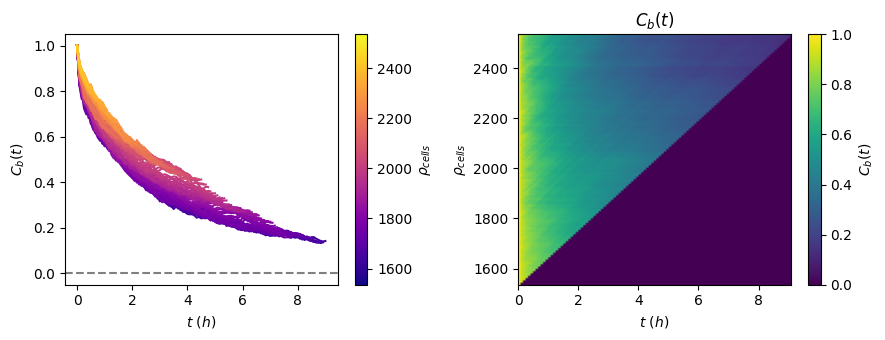

In [114]:
# prepare to plot
frames = np.arange(Nframes) * frames_to_hours

# define density colormap
densities  = np.array(densities)
Ndensities = len(densities)

cmap   = mpl.colormaps['plasma']
colors = cmap(np.linspace(0.1, 0.9, Ndensities))
sm     = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=densities.min(), vmax=densities.max()))


fig, ax = plt.subplots(1,2, figsize=(9,3.5))

ax[0].axhline(0, ls='dashed', color="gray")
im = ax[1].imshow(bond_breaking, aspect="auto", extent=[0, Nframes*frames_to_hours, densities.min(), densities.max()])

for i in range(Nframes):
    ax[0].plot(frames[bond_breaking[i] > 0], bond_breaking[i][bond_breaking[i] > 0], color=colors[i])


ax[0].set(xlabel="$t ~(h)$", ylabel=r"$C_b(t)$")
ax[1].set(xlabel="$t ~(h)$", ylabel=r"$\rho_{cells}$", title=r"$C_b(t)$")

fig.colorbar(sm, ax=ax[0], label=r"$\rho_{cells}$")
fig.colorbar(im, ax=ax[1], label=r"$C_b(t)$")
fig.tight_layout()
fig.savefig(f"results/{dataset}/bond_breaking_correlation.png", dpi=300)

In [115]:
np.save(f"data/experimental/processed/{dataset}/bond_breaking_correlation.npy", bond_breaking)
np.save(f"data/experimental/processed/{dataset}/densities.npy", densities)

In [69]:
import numpy as np

def self_intermediate_scattering_function_radial(x, y, q, t_max=None):
        
    # Maximum time if not specified
    if t_max is None:
        t_max = x.shape[0]  # number of rows
    
    # Initialize SISF array
    SISF = np.zeros(t_max)
    
    # Loop over time
    for t in range(t_max):
        # Number of particles
        N = x.shape[1]  # number of columns

        # Compute the radial distance for each particle
        dx = x[t, :] - x[0, :]  # displacement in x
        dy = y[t, :] - y[0, :]  # displacement in y
        dr = np.ma.sqrt(dx**2 + dy**2)
        
        # Calculate the SISF using the average of exp(i * q * r)
        # Assume q is a scalar radial distance (magnitude)
        exp_term = np.exp(1j * q * dr)
        
        # Calculate the average
        SISF[t] = np.real(np.ma.mean(exp_term))
    
    return SISF


In [ ]:
import numpy as np

def self_intermediate_scattering_function(x, y, q, t_max=None):
    # Number of particles
    N = x.shape[1]  # number of columns
    
    # Maximum time if not specified
    if t_max is None:
        t_max = x.shape[0]  # number of rows
    
    # Initialize SISF array
    SISF = np.zeros(t_max)
    
    # Loop over time
    for t in range(t_max):
        # Compute the displacement
        r_j_t = np.ma.array([x[t, :], y[t, :]])
        r_j_0 = np.ma.array([x[0, :], y[0, :]])
        displacements = r_j_t - r_j_0
        
        # Calculate the SISF 
        # Note: We use q dot displacement, where q is treated as a 2D vector [q_x, q_y]
        qx = q[0]
        qy = q[1]
        
        exp_term = np.ma.exp(1j * (qx * displacements[0, :] + qy * displacements[1, :]))
        
        # Calculate the average
        SISF[t] = np.real(np.ma.sum(exp_term)) / N
    
    return SISF


In [70]:
sisf_t = self_intermediate_scattering_function_radial(cellprop.x, cellprop.y, 0, t_max=1)
sisf_t

array([1.])

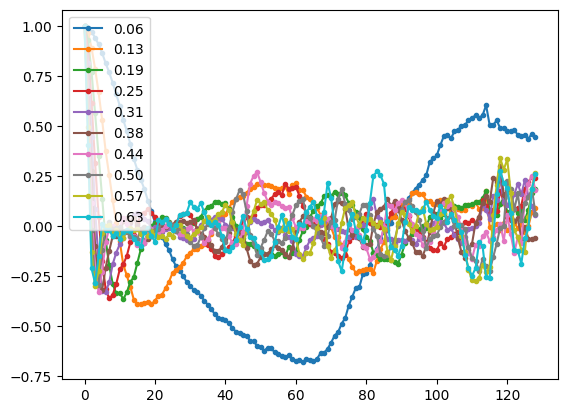

In [ ]:
N = 100
q_arr = []

for i in range(1,N):

    q = i*2*np.pi / N #[i*2*np.pi / N, i*2*np.pi / N]
    sisf_t = self_intermediate_scattering_function_radial(cellprop.x, cellprop.y, q)

    if sisf_t[1] > 0.4:
        q_arr.append(q)
        plt.plot(sisf_t, '.-', label=f"{q:0.2f}")

    #sisf_t = self_intermediate_scattering_function(cellprop.x, cellprop.y, q)
plt.legend()

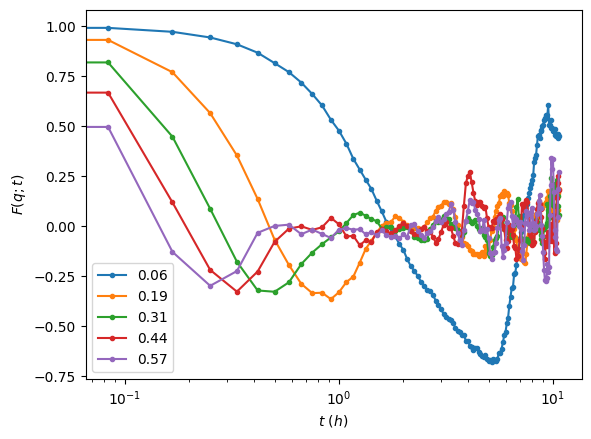

In [84]:
t_arr = np.arange(len(cellprop.x)) / 12
for q in q_arr[0:-1:2]:

    sisf_t = self_intermediate_scattering_function_radial(cellprop.x, cellprop.y, q)
    plt.plot(t_arr, sisf_t, '.-', label=f"{q:0.2f}")

    #sisf_t = self_intermediate_scattering_function(cellprop.x, cellprop.y, q)
plt.legend()
plt.xscale("log")
plt.xlabel(r"$t ~(h)$")
plt.ylabel(r"$F(q;t)$")
plt.savefig(f"results/{dataset}/self_intermediate_scattering.png", dpi=300)

In [ ]:

# Example usage
# Create dummy data for positions of particles over time
# Let's say we have 10 particles observed for 5 time steps
time_steps = 5
particles = 10
x = np.random.rand(time_steps, particles)
y = np.random.rand(time_steps, particles)

# Define q (as an example)
q = np.array([1.0, 0.0])  # For example q_x = 1.0, q_y = 0.0

# Calculate the SISF
sisf_result = self_intermediate_scattering_function(x, y, q)
print(sisf_result)